In [1]:
import sys
import os.path
import torch
import PIL
import numpy as np
import pdb
import uuid
import torch.nn.functional as F
import vipy.image
import vipy.visualize
import vipy.util
import tempfile

xfr_path = '/home/swchiu/research/packages/xfr'
sys.path.append(os.path.join(xfr_path, 'python'))
from xfr.models.whitebox import WhiteboxSTResnet, Whitebox
from xfr.models.resnet import stresnet101
import xfr.models.whitebox
import xfr.show

def _blend_saliency_map(img, smap, overlap, scale_factor=1.0, gamma=0.3, blur_sigma=0.05):
    """Input is PIL image, smap is real valued saliency map, output is PIL image"""
#     img_blend = xfr.show.blend_saliency_map(np.array(img).astype(np.float32)/255.0, smap, blur_sigma=blur_sigma, gamma=gamma, scale_factor=scale_factor)
    img_blend = xfr.show.ReturnComparison([np.array(img).astype(np.float32)/255.0], [smap], overlap=overlap, blur=False, blur_sigma=blur_sigma, gamma=gamma, scale_factor=scale_factor)[0]
    return PIL.Image.fromarray(np.uint8(img_blend*255))  # [0,255] PIL image

def ebp(wb, img_path, outfile, device, overlap=False):
    """Excitation backprop in pytorch"""

    # Create whitebox object with STR-Janus resnet-101 convolutional network
    x_probe = wb.net.preprocess(PIL.Image.open(img_path))
    x_probe = x_probe.to(device)

    # Generate Excitation backprop (EBP) saliency map at first convolutional layer
    P = torch.zeros( (1, wb.net.num_classes()) );  P[0][0] = 1.0;  # one-hot prior probability
    P = P.to(device)
    img_saliency = wb.ebp(x_probe, P)

    # Overlay saliency map with display image
    img_display = PIL.Image.open(img_path)

    return _blend_saliency_map(img_display, img_saliency, overlap)

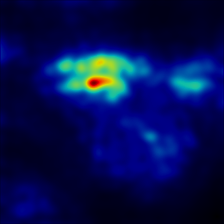

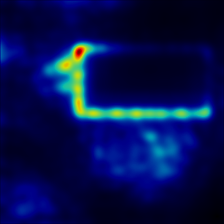

In [2]:
device = torch.device('cuda')
xai_model_path = os.path.join(xfr_path, 'models/resnet101v4_28NOV17_train.pth')
xai_model = stresnet101(xai_model_path, device)
wb = Whitebox(WhiteboxSTResnet(xai_model))

orig_img = '/mnt/disk1/vggface2_224/n004316/0259_03.jpg'
barm_img = '/mnt/disk1/vggface2_224_bar_mask_4/n004316/0259_03.jpg'

att_map = ebp(wb, orig_img, '', device, overlap=False)
att_map.show()
att_map = ebp(wb, barm_img, '', device, overlap=False)
att_map.show()